# Hadza Market Integration -- Bibliometric Analysis

Berbesque & Hoover (2025), *Journal of Development Studies*  
DOI: [10.1080/00220388.2025.2555188](https://doi.org/10.1080/00220388.2025.2555188)

This notebook produces the bibliometric figures supporting the argument that decades of external research and tourism bias toward men's activities may have contributed to the sex-based childhood health disparity identified in the main analysis.

**Outputs:**
- `revised-fig3.png` -- publication timeline dotplot (Hadza men vs women research, 1999--2024)
- `revised-fig4-women-network.png` -- keyword co-occurrence network, Hadza women research
- `revised-fig5-men-network.png` -- keyword co-occurrence network, Hadza men research

---

## Data Sources

### Publication timeline (Figure 3)
Data retrieved from [dimensions.ai](https://dimensions.ai) using the search terms documented in the paper (Section 2.2.5):
- `Hadza AND men NOT women` (titles and abstracts)
- `Hadza AND women NOT men` (titles and abstracts)

Shared in this repo as stripped CSVs (`Publication ID`, `Title`, `PubYear`, `DOI` only):
- `revised-data-hadzamen-20250502.csv`
- `revised-data-hadzawomen-20250502.csv`

To reproduce the original Excel exports exactly, run the search on dimensions.ai with an end date of **5/2/2025** (women retrieved 10:14 AM, men 10:15 AM). See the commented-out cell below for the stripping steps.

### Co-occurrence networks (Figures 4--5)
Network JSON files exported from the dimensions.ai Analytics tab (VOSviewer format) using the same search terms. Export date: **5/7/2025**. These files are not shared in the repo as they are Dimensions analytics output. To reproduce: run the search, go to the Analytics tab, select Concept co-occurrence network, export as JSON.
- `network-hadzamen-titleAbs.json`
- `network-hadzawomen-titleAbs.json`

## Libraries

In [1]:
import json
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

## Excel to CSV (run once to reproduce stripped data files)

This cell strips the raw Dimensions Excel exports to the four columns needed for Figure 3 and saves them as CSVs for sharing. The Excel files are not shared in the repo. Run this cell only if reproducing from a fresh Dimensions export; otherwise skip to the next section which reads the CSVs directly.

In [2]:
# # Uncomment and run once to regenerate CSVs from raw Excel exports
# # Excel files retrieved from dimensions.ai on 5/2/2025
# # Women: 10:14 AM | Men: 10:15 AM
# # Search terms: 'Hadza AND men NOT women' and 'Hadza AND women NOT men' (titles and abstracts)
# # men_raw = pd.read_excel('hrevised-adzaMen_titleAbstract.xlsx', skiprows=1)
# # women_raw = pd.read_excel('revised-hadzaWomen_titleAbstract.xlsx', skiprows=1)
# # men_raw[['Publication ID', 'Title', 'PubYear', 'DOI']].to_csv('data-hadzamen-20250502.csv', index=False)
# # women_raw[['Publication ID', 'Title', 'PubYear', 'DOI']].to_csv('data-hadzawomen-20250502.csv', index=False)
# # print('CSVs saved')

## Figure 3 -- Publication Timeline

Publication counts by year for research focused on Hadza men vs Hadza women. Point size scales with the number of publications in that year. Two early publications (1975 for men, 1992 for women) fall outside the main publication period; the x-axis starts at 1999 where the sustained record begins.

The crossover around 2015 reflects a cohort of female researchers entering the field, shifting the historical imbalance in research attention toward women.

In [3]:
# load stripped CSVs
men = pd.read_csv('data-hadzamen-20250502.csv')
women = pd.read_csv('data-hadzawomen-20250502.csv')

# aggregate by year
men_agg = men.groupby('PubYear').size().reset_index(name='total_count')
men_agg['dataset'] = 'Hadza_Men'

women_agg = women.groupby('PubYear').size().reset_index(name='total_count')
women_agg['dataset'] = 'Hadza_Women'

pubs = pd.concat([men_agg, women_agg], ignore_index=True)
pubs = pubs[pubs['PubYear'] >= 1999].copy()

print(f"Men publications (1999+): {men_agg[men_agg.PubYear >= 1999].total_count.sum()}")
print(f"Women publications (1999+): {women_agg[women_agg.PubYear >= 1999].total_count.sum()}")

Men publications (1999+): 35
Women publications (1999+): 17


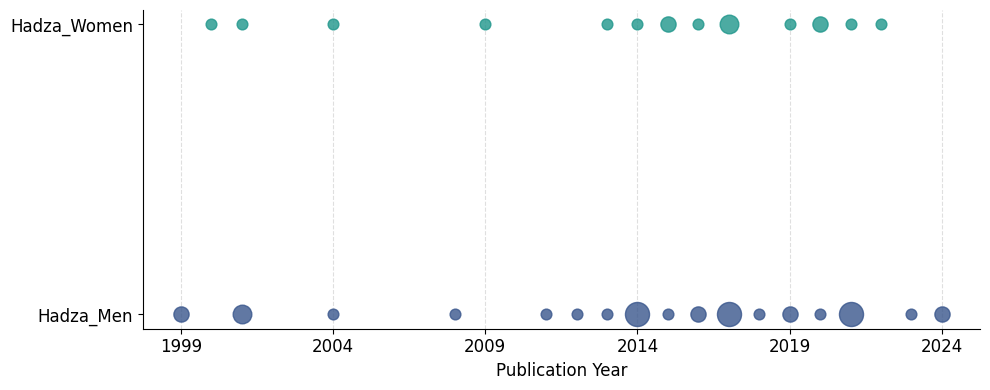

Saved: revised-fig3.png


In [4]:
# plot timeline
colors = {'Hadza_Men': '#39568C', 'Hadza_Women': '#1F968B'}
y_positions = {'Hadza_Men': 0, 'Hadza_Women': 1}

fig, ax = plt.subplots(figsize=(10, 4))

for _, row in pubs.iterrows():
    ax.scatter(
        row['PubYear'],
        y_positions[row['dataset']],
        s=row['total_count'] * 60,
        color=colors[row['dataset']],
        alpha=0.8,
        zorder=3
    )

ax.set_yticks([0, 1])
ax.set_yticklabels(['Hadza_Men', 'Hadza_Women'], fontsize=12)
ax.set_xlabel('Publication Year', fontsize=12)
ax.set_ylabel('')

max_year = int(pubs['PubYear'].max())
ax.set_xticks(range(1999, max_year + 1, 5))
ax.tick_params(axis='x', labelsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('revised-fig3.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: revised-fig3.png')

## Figures 4--5 -- Keyword Co-occurrence Networks

Co-occurrence networks built from concept terms in publication titles and abstracts, exported from dimensions.ai analytics. Each network shows the ego network of the primary search term -- all concepts that co-occur directly with 'Hadza women' or 'Hadza men'.

Node size reflects term occurrence frequency; node color reflects cluster membership (thematic groupings assigned by the VOSviewer algorithm); edge width reflects co-occurrence strength.

Network metrics are printed below each figure for reference.

In [37]:
def load_network(file_path):
    """Load co-occurrence network from dimensions.ai VOSviewer JSON export."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    G = nx.Graph()
    node_cluster = {}
    if 'network' in data and 'items' in data['network']:
        for item in data['network']['items']:
            node_id = item['id']
            attributes = {k: v for k, v in item.items()
                          if k not in ['id', 'x', 'y', 'cluster']}
            G.add_node(node_id, **attributes)
            node_cluster[node_id] = item.get('cluster')
    if 'network' in data and 'links' in data['network']:
        for link in data['network']['links']:
            source = link.get('source_id')
            target = link.get('target_id')
            weight = link.get('strength', 1)
            if source and target:
                G.add_edge(source, target, weight=weight)
    return G, node_cluster


def get_focus_subgraph(G, focus_term):
    """Extract ego network: focus term and all direct neighbors."""
    neighbors = set([focus_term])
    for u, v in G.edges():
        if u == focus_term or v == focus_term:
            neighbors.add(u)
            neighbors.add(v)
    return G.subgraph(neighbors)


def print_network_metrics(G, title):
    """Print key network metrics."""
    print(f'\n--- {title} ---')
    print(f'Nodes: {G.number_of_nodes()}')
    print(f'Edges: {G.number_of_edges()}')
    if G.number_of_nodes() > 0:
        avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
        print(f'Average degree: {avg_degree:.2f}')
        print(f'Network density: {nx.density(G):.2f}')
        print(f'Average clustering coefficient: {nx.average_clustering(G):.2f}')
    if nx.is_connected(G):
        communities = nx.algorithms.community.greedy_modularity_communities(G)
        mod = nx.algorithms.community.quality.modularity(G, communities)
        print(f'Modularity: {mod:.2f}')
    else:
        print('Modularity: not defined (disconnected graph)')


def plot_network(G, node_cluster, output_path, title=''):
    """Visualize focused co-occurrence network with cluster colors."""
    clusters = sorted(set(node_cluster.values()))
    palette = [
        '#1f78b4', '#33a02c', '#a6cee3', '#b2df8a', '#fb9a99',
        '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a',
        '#ffff99', '#b15928'
    ]
    cluster_color = {c: palette[i % len(palette)] for i, c in enumerate(clusters)}
    node_colors = [
        cluster_color.get(node_cluster.get(node), 'gray')
        for node in G.nodes()
    ]
    node_sizes = [
        G.nodes[node].get('weights', {}).get('Occurrences', 5) * 120
        for node in G.nodes()
    ]
    edge_widths = [
        G.edges[u, v].get('weight', 1) / 5
        for u, v in G.edges()
    ]
    fig, ax = plt.subplots(figsize=(12, 12))
    pos = nx.spring_layout(G, k=1.0, iterations=300, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                           node_color=node_colors, alpha=0.7, ax=ax)
    nx.draw_networkx_edges(G, pos, width=edge_widths,
                           edge_color='gray', alpha=0.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10,
                            font_family='sans-serif', ax=ax)
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f'Saved: {output_path}')

### Figure 4 -- Hadza Women Network

Dense, highly interconnected network dominated by postpartum health, cortisol and stress, social relationships, and demography. Reflects a shorter research history with tightly coupled thematic focus.

In [38]:
women_G, women_clusters = load_network('network-hadzawomen-titleAbs.json')
women_sub = get_focus_subgraph(women_G, 'Hadza women')
women_sub_clusters = {n: women_clusters.get(n) for n in women_sub.nodes()}

print_network_metrics(women_sub, 'Hadza Women Co-occurrence Network')
plot_network(women_sub, women_sub_clusters,
             'revised-fig4-women-network.png',
             title='')


--- Hadza Women Co-occurrence Network ---
Nodes: 33
Edges: 470
Average degree: 28.48
Network density: 0.89
Average clustering coefficient: 0.99
Modularity: 0.03
Saved: revised-fig4-women-network.png


### Figure 5 -- Hadza Men Network

Sparse, modular network with distinct thematic clusters: hunting and status, genetics, paternal provisioning, subsistence skills, wealth. Greater node count reflects longer research history and multiple independent research programs.

In [28]:
men_G, men_clusters = load_network('network-hadzamen-titleAbs.json')
men_sub = get_focus_subgraph(men_G, 'Hadza men')
men_sub_clusters = {n: men_clusters.get(n) for n in men_sub.nodes()}

print_network_metrics(men_sub, 'Hadza Men Co-occurrence Network')
plot_network(men_sub, men_sub_clusters,
             'revised-fig5-men-network.png',
             title='')


--- Hadza Men Co-occurrence Network ---
Nodes: 73
Edges: 564
Average degree: 15.45
Network density: 0.21
Average clustering coefficient: 0.90
Modularity: 0.46
Saved: revised-fig5-men-network.png
